[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_sparse.ipynb)

In [ ]:
try:
    # Check if notebook is running in Google Colab
    import google.colab
    # Get additional files from Github
    !wget https://raw.githubusercontent.com/krasserm/bayesian-machine-learning/dev/gaussian-processes/gaussian_processes_util.py
except:
    pass

# Sparse Gaussian processes

## Introduction

Exact Gaussian processes cannot be applied to larger training datasets because their time complexity scales with $O(n^3)$ where $n$ is the size of the training set. Approximate or sparse Gaussian processes are based on a small set of $m$ inducing variables that reduce the time complexity to $O(nm^2)$. 

In this article I give an introduction to sparse Gaussian processes as described in \[1\] and provide a simple implementation with [JAX](https://github.com/google/jax). The main reason for using JAX instead of plain NumPy was the need to compute gradients of the variational lower bound. The mathematical descriptions in this article are kept on a rather high level so that the focus is on intuition rather than on a detailed derivation of equations. 

### Exact Gaussian processes

In a [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes_classification.ipynb) I introduced exact Gaussian processes for regression. A Gaussian process is a [random process](https://en.wikipedia.org/wiki/Stochastic_process) where any point $\mathbf{x} \in \mathbb{R}^d$ is assigned a random variable $f(\mathbf{x})$ and where the joint distribution of a finite number of these variables $p(f(\mathbf{x}_1),...,f(\mathbf{x}_N)) = p(\mathbf{f} \mid \mathbf{X}) = \mathcal{N}(\mathbf{f} \mid \boldsymbol\mu, \mathbf{K})$ is itself Gaussian. Covariance matrix $\mathbf{K}$ is defined by a kernel function $\kappa$ where $\mathbf{K} = \kappa(\mathbf{X},\mathbf{X})$. Mean $\boldsymbol\mu$ is often set to $\mathbf{0}$. A GP can be used to define a prior over functions.

A GP prior can be converted into a posterior by conditioning on a training dataset $\mathbf{X}, \mathbf{y}$ where $\mathbf{y}$ are noisy realizations of function values $\mathbf{f}$. For independent Gaussian noise we have $y_i = f(\mathbf{x}_i) + \epsilon_i$ where $\epsilon_i \sim \mathcal{N}(0, \sigma_y^2)$. Noise-free training function values $\mathbf{f}$ are not directly observed i.e. are latent variables. The posterior over function values $\mathbf{f}_*$ at inputs $\mathbf{X}_*$ conditioned on training data is given by

$$
\begin{align*}
p(\mathbf{f}_* \mid \mathbf{X}_*,\mathbf{X},\mathbf{y}) &= \mathcal{N}(\mathbf{f}_* \mid \boldsymbol{\mu}_*, \boldsymbol{\Sigma}_*)\tag{1} \\
\boldsymbol{\mu}_* &= \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{y}\tag{2} \\
\boldsymbol{\Sigma}_* &= \mathbf{K}_{**} - \mathbf{K}_*^T \mathbf{K}_y^{-1} \mathbf{K}_*\tag{3}
\end{align*}
$$

where $\mathbf{K}_y = \mathbf{K} + \sigma_y^2\mathbf{I}$, $\mathbf{K}_* = \kappa(\mathbf{X},\mathbf{X}_*)$ and $\mathbf{K}_{**} = \kappa(\mathbf{X}_*,\mathbf{X}_*)$. It can be used to predict function values $\mathbf{f}_*$ at new inputs $\mathbf{X}_*$. Computation of $\boldsymbol{\mu}_*$ and $\boldsymbol{\Sigma}_*$ requires the inversion of $\mathbf{K}_y$, an $n \times n$ matrix, where $n$ is the size of the training set. Matrix inversion becomes computationally intractable for larger $n$. To outline a solution to this problem, we note that the posterior can also be defined as

$$
p(\mathbf{f}_* \mid \mathbf{y}) = \int p(\mathbf{f}_* \mid \mathbf{f}) p(\mathbf{f} \mid \mathbf{y}) d\mathbf{f} \tag{4}
$$

where the conditioning on inputs $\mathbf{X}$ and $\mathbf{X}_*$ has been made implicit. The second term inside the integral is the posterior over the training latent variables $\mathbf{f}$ conditioned on observations $\mathbf{y}$, the first term is the posterior over predictions $\mathbf{f}_*$ conditioned on latent training variables $\mathbf{f}$ (see also equation $(3)$ in [this article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/dev/gaussian-processes/gaussian_processes.ipynb)). Both terms are intractable to compute for larger training datasets for reasons explained above.

### Sparse Gaussian processes

Suppose there is a small set of $m$ inducing variables $\mathbf{f}_m$ evaluated at inputs $\mathbf{X}_m$ that describe the function to be modeled "sufficiently well" then we could use them as approximation to $\mathbf{f}$ and $\mathbf{X}$ and define an approximate posterior

$$
q(\mathbf{f}_*) = \int p(\mathbf{f}_* \mid \mathbf{f}_m) \phi(\mathbf{f}_m) d\mathbf{f}_m \tag{5}
$$

where $\phi(\mathbf{f}_m)$ is an approximation to the intractable $p(\mathbf{f}_m \mid \mathbf{y})$:

$$
\phi(\mathbf{f}_m) = \mathcal{N}(\mathbf{f}_m \mid \boldsymbol{\mu}_m, \mathbf{A}_m) \tag{6}
$$

Goal is to find optimal values for mean $\boldsymbol{\mu}_m$ and covariance matrix $\mathbf{A}_m$. The quality of $\phi(\mathbf{f}_m)$ also depends on the location of the inducing inputs $\mathbf{X}_m$, hence, our goal is to find their optimal values as well. The mean and covariance matrix of the Gaussian approximate posterior $q(\mathbf{f}_*)$ are defined in terms of $\boldsymbol{\mu}_m$, $\mathbf{A}_m$ and $\mathbf{X}_m$:

$$
\begin{align*}
q(\mathbf{f}_*) &= \mathcal{N}(\mathbf{f}_* \mid \boldsymbol{\mu}_*^q, \boldsymbol{\Sigma}_*^q) \tag{7} \\
\boldsymbol{\mu}_*^q &= \mathbf{K}_{*m} \mathbf{K}_{mm}^{-1} \boldsymbol{\mu}_m \tag{8} \\
\boldsymbol{\Sigma}_*^q &= \mathbf{K}_{**} - \mathbf{K}_{*m} \mathbf{K}_{mm}^{-1} \mathbf{K}_{m*} + \mathbf{K}_{*m} \mathbf{K}_{mm}^{-1} \mathbf{A}_m \mathbf{K}_{mm}^{-1} \mathbf{K}_{m*} \tag{9}
\end{align*}
$$

where $\mathbf{K}_{mm} = \kappa(\mathbf{X}_m, \mathbf{X}_m)$, $\mathbf{K}_{*m} = \kappa(\mathbf{X}_*, \mathbf{X}_m)$ and $\mathbf{K}_{m*} = \mathbf{K}_{*m}^T$. For a single test input, this approximate posterior can be computed in $O(nm^2)$ after having found optimal values for $\boldsymbol{\mu}_m$, $\mathbf{A}_m$ and $\mathbf{X}_m$. \[1\] uses a variational approach for optimizing $\boldsymbol{\mu}_m$, $\mathbf{A}_m$ and $\mathbf{X}_m$ by minimizing the Kullback-Leibler (KL) divergence between the approximate posterior $q(\mathbf{f})$ and the exact posterior $p(\mathbf{f} \mid \mathbf{y})$ over training latent variables $\mathbf{f}$.

Minimization of this KL divergence is equivalent to maximization of a lower bound $\mathcal{L}(\boldsymbol{\mu}_m, \mathbf{A}_m, \mathbf{X}_m)$ on the true log marginal likelihood $\log p(\mathbf{y})$. This lower bound can be optimized by analytically solving for $\boldsymbol{\mu}_m$ and $\mathbf{A}_m$. The resulting lower bound after optimization is a function of $\mathbf{X}_m$:

$$
\mathcal{L}(\mathbf{X}_m) = \log \mathcal{N} (\mathbf{y} \mid \mathbf{0}, \sigma_y^2 \mathbf{I} + \mathbf{Q}_{nn}) - \frac{1}{2 \sigma_y^2} \mathrm{Tr}(\mathbf{K}_{nn} - \mathbf{Q}_{nn}) \tag{10}
$$


where $\mathbf{Q}_{nn} = \mathbf{K}_{nm} \mathbf{K}_{mm}^{-1} \mathbf{K}_{mn}$, $\mathbf{K}_{nn} = \kappa(\mathbf{X},\mathbf{X})$, $\mathbf{K}_{nm} = \kappa(\mathbf{X},\mathbf{X}_m)$ and $\mathbf{K}_{mn} = \mathbf{K}_{nm}^T$. Equation $(10)$ can be computed in $O(nm^2)$, as shown in section [Optimization](#Optimization), and used to optimize inducing inputs $\mathbf{X}_m$ jointly with kernel hyperparamaters using a numeric optimization method. The first term on the RHS is an approximate log likelihood term. Optimizing this term alone could lead to overfitting.

The second term is a regularization term which is a result of using a variational approach. This term can be interpreted as minimizing the error predicting $\mathbf{f}$ from inducing variables $\mathbf{f}_m$. The better the variables $\mathbf{f}_m$ represent the function to be modeled the smaller this error will be. Hence, optimization will try to find optimal positions for inducing inputs $\mathbf{X}_m$. With optimal values for $\mathbf{X}_m$, we can optimize $\boldsymbol{\mu}_m$ and $\mathbf{A}_m$ i.e. the parameters of $\phi(\mathbf{f}_m)$ analytically with 

$$
\begin{align*}
\boldsymbol{\mu}_m &= \frac{1}{\sigma_y^2} \mathbf{K}_{mm} \boldsymbol{\Sigma} \mathbf{K}_{mn} \mathbf{y} \tag{11} \\
\mathbf{A}_m &= \mathbf{K}_{mm} \boldsymbol{\Sigma} \mathbf{K}_{mm} \tag{12}
\end{align*}
$$

where $\boldsymbol{\Sigma} = (\mathbf{K}_{mm} + \sigma_y^{-2} \mathbf{K}_{mn} \mathbf{K}_{nm})^{-1}$. $\boldsymbol{\mu}_m$ and $\mathbf{A}_m$ are then substituted into equations $(8)$ and $(9)$ to compute the approximate posterior $q(\mathbf{f}_*)$ at new inputs $\mathbf{X}_*$. This is the minimum we need to know for implementing sparse Gaussian processes for regression. 

## Implementation

In [1]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsp
import matplotlib.pyplot as plt

from jax import random, jit, value_and_grad
from jax.config import config
from scipy.optimize import minimize

config.update("jax_enable_x64", True)
%matplotlib inline

### Training dataset

The training dataset is taken from [this example](https://gpflow.readthedocs.io/en/master/notebooks/advanced/gps_for_big_data.html#Generating-data) of the [GPflow](https://gpflow.readthedocs.io/)<sup>\[2\]</sup> project. We'll use `n` noisy training examples drawn from `func` with Gaussian noise `sigma_y`. The number of inducing variables is `m`.

In [2]:
def func(x):
    """Latent function."""
    return 1.0 * jnp.sin(x * 3 * jnp.pi) + \
           0.3 * jnp.cos(x * 9 * jnp.pi) + \
           0.5 * jnp.sin(x * 7 * jnp.pi)


# Number of training examples
n = 1000

# Number of inducing variables
m = 30

# Noise
sigma_y = 0.2

# Noisy training data
X = jnp.linspace(-1.0, 1.0, n).reshape(-1, 1)
y = func(X) + sigma_y * random.normal(random.PRNGKey(0), shape=(n, 1))

# Test data
X_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
f_true = func(X_test)

# Inducing inputs
X_m = jnp.linspace(-0.4, 0.4, m).reshape(-1, 1)

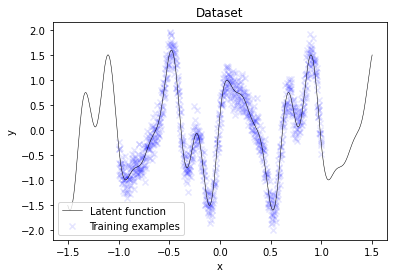

In [3]:
plt.scatter(X, y, label='Training examples', marker='x', color='blue', alpha=0.1)
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.title('Dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

A useful initial placement of inducing inputs `X_m` would be to uniformly distribute them across the entire training data region. Here, they are placed in a narrower interval for better [visualization of the optimization process](#Visualizing-the-optimization-process) later.

### Kernel

As in previous articles, we'll again use an isotropic squared exponential kernel with length parameter `theta[0]` and multiplicative constant `theta[1]`. These parameters will be optimized together with inducing inputs `X_m` as shown in the next section.

In [4]:
def kernel(X1, X2, theta):
    """
    Isotropic squared exponential kernel.
    
    Args:
        X1: Array of m points (m, d).
        X2: Array of n points (n, d).
        theta: kernel parameters (2,)
    """

    sqdist = jnp.sum(X1 ** 2, 1).reshape(-1, 1) + jnp.sum(X2 ** 2, 1) - 2 * jnp.dot(X1, X2.T)
    return theta[1] ** 2 * jnp.exp(-0.5 / theta[0] ** 2 * sqdist)


def kernel_diag(d, theta):
    """
    Isotropic squared exponential kernel (computes diagonal elements only).
    """
    return jnp.full(shape=d, fill_value=theta[1] ** 2)

### Optimization

A naive implementation of lower bound $\mathcal{L}(\mathbf{X}_m)$ as defined in equation $(10)$ is numerically unstable. A numerically stable approach is described [here](https://gpflow.readthedocs.io/en/master/notebooks/theory/SGPR_notes.html#Marginal-likelihood-bound) which derives the following expression for the lower bound:

$$
\begin{align*}
\mathcal{L}(\mathbf{X}_m) = 
&- \frac{n}{2} \log 2 \pi
- \frac{1}{2} \log \begin{vmatrix}\mathbf{B}\end{vmatrix}
- \frac{n}{2} \log \sigma_y^2
- \frac{1}{2 \sigma_y^2} \mathbf{y}^T \mathbf{y} \\
&+ \frac{1}{2} \mathbf{c}^T \mathbf{c}
- \frac{1}{2 \sigma_y^2} \mathrm{Tr}(\mathbf{K}_{nn})
+ \frac{1}{2} \mathrm{Tr}(\mathbf{A}\mathbf{A}^T) \tag{13}
\end{align*}
$$

where $\mathbf{c} = \mathbf{L_B}^{-1} \mathbf{A} \mathbf{y} \sigma_y^{-1}$, $\mathbf{B} = \mathbf{I} + \mathbf{A}\mathbf{A}^T$ and $\mathbf{A} = \mathbf{L}^{-1} \mathbf{K}_{mn} \sigma_y^{-1}$. Lower-triangular matrices $\mathbf{L_B}$ and $\mathbf{L}$ are obtained from a [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition) of $\mathbf{B} = \mathbf{L_B} \mathbf{L_B}^T$ and $\mathbf{K}_{mm} = \mathbf{L} \mathbf{L}^T$, respectively. $\mathbf{c}$ and $\mathbf{A}$ are obtained by solving the equations $\mathbf{L_B} \mathbf{c} = \mathbf{A} \mathbf{y} \sigma_y^{-1}$ and $\mathbf{L} \mathbf{A} = \mathbf{K}_{mn} \sigma_y^{-1}$, respectively. The log determinant of $\mathbf{B}$ is $2 \sum_{i=1}^m \log {L_B}_{ii}$ as explained in [this post](https://math.stackexchange.com/a/3211219/648651), for example. Using these definitions, a numerically stable implementation of a negative lower bound (`nlb`) is straightforward.

In [5]:
def jitter(d, value=1e-6):
    return jnp.eye(d) * value


def softplus(X):
    return jnp.log(1 + jnp.exp(X))


def softplus_inv(X):
    return jnp.log(jnp.exp(X) - 1)


def pack_params(theta, X_m):
    return jnp.concatenate([softplus_inv(theta), X_m.ravel()])


def unpack_params(params):
    return softplus(params[:2]), jnp.array(params[2:].reshape(-1, 1))


def nlb_fn(X, y, sigma_y):
    n = X.shape[0]

    def nlb(params):
        """
        Negative lower bound on log marginal likelihood.
        
        Args:
            params: kernel parameters `theta` and inducing inputs `X_m`
        """
        
        theta, X_m = unpack_params(params)

        K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
        K_mn = kernel(X_m, X, theta)

        L = jnp.linalg.cholesky(K_mm)  # m x m
        A = jsp.linalg.solve_triangular(L, K_mn, lower=True) / sigma_y  # m x n        
        AAT = A @ A.T  # m x m
        B = jnp.eye(X_m.shape[0]) + AAT  # m x m
        LB = jnp.linalg.cholesky(B)  # m x m
        c = jsp.linalg.solve_triangular(LB, A.dot(y), lower=True) / sigma_y  # m x 1

        # Equation (13)
        lb = - n / 2 * jnp.log(2 * jnp.pi)
        lb -= jnp.sum(jnp.log(jnp.diag(LB)))
        lb -= n / 2 * jnp.log(sigma_y ** 2)
        lb -= 0.5 / sigma_y ** 2 * y.T.dot(y)
        lb += 0.5 * c.T.dot(c)
        lb -= 0.5 / sigma_y ** 2 * jnp.sum(kernel_diag(n, theta))
        lb += 0.5 * jnp.trace(AAT)

        return -lb[0, 0]

    # nlb_grad returns the negative lower bound and 
    # its gradient w.r.t. params i.e. theta and X_m.
    nlb_grad = jit(value_and_grad(nlb))

    def nlb_grad_wrapper(params):
        value, grads = nlb_grad(params)
        # scipy.optimize.minimize cannot handle
        # JAX DeviceArray directly. a conversion
        # to Numpy ndarray is needed.
        return np.array(value), np.array(grads)

    return nlb_grad_wrapper

The parameters to be optimized are passed as `params` to function `nlb`. These are a concatenation of kernel hyperparameters `theta` and inducing inputs `X_m`. To enable an unconstrained optimization, the kernel hyperparameters are transformed with a [softplus](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus) function. The noise variance `sigma_y ** 2` is used as constant here but it is trivial make it an additional parameter to be optimized.

Function `nlb_grad` does not only return the negative lower bound value for a given value of `params` but also its gradient w.r.t. `params`. The gradient can be readily obtained in addition to the lower bound value by transforming `nlb` with JAX's `value_and_grad`. Providing the gradients to the optimizer leads to a much faster convergence compared to letting the optimizer estimate the gradients itself.

JAX doesn't seem to provide an implementation of the L-BFGS-B optimizer yet, therefore, we use SciPy's implementation of `minimize(..., method='L-BFGS-B')`. Since this optimizer cannot handle JAX `DeviceArray`s the result of `nlb` must be converted to plain NumPy `ndarray`s with `nlb_grad_wrapper`.

In [6]:
# Run optimization
res = minimize(fun=nlb_fn(X, y, sigma_y),
               x0=pack_params(jnp.array([1.0, 1.0]), X_m),
               method='L-BFGS-B',
               jac=True)

# Optimized kernel parameters and inducing inputs
theta_opt, X_m_opt = unpack_params(res.x)

With optimal values for kernel hyperparameters `theta_opt` and inducing inputs `X_m_opt`, we can now optimize $\boldsymbol{\mu}_m$ and $\mathbf{A}_m$ analytically using equations $(11)$ and $(12)$ to obtain `mu_m_opt` and `A_m_opt`, respectively. We use a naive implementation here i.e. directly invert matrices with `jnp.linalg.inv`.

In [7]:
@jit
def phi_opt(theta, X_m, X, y, sigma_y):
    """Optimize mu_m and A_m using Equations (11) and (12)."""
    precision = (1.0 / sigma_y ** 2)

    K_mm = kernel(X_m, X_m, theta) + jitter(X_m.shape[0])
    K_mm_inv = jnp.linalg.inv(K_mm)
    K_nm = kernel(X, X_m, theta)
    K_mn = K_nm.T
    
    Sigma = jnp.linalg.inv(K_mm + precision * K_mn @ K_nm)
    
    mu_m = precision * (K_mm @ Sigma @ K_mn).dot(y)
    A_m = K_mm @ Sigma @ K_mm    
    
    return mu_m, A_m, K_mm_inv

mu_m_opt, A_m_opt, K_mm_inv = phi_opt(theta_opt, X_m_opt, X, y, sigma_y)

After plotting the results, one can clearly see that the optimized inducing variables represent the function to be modeled reasonably well.

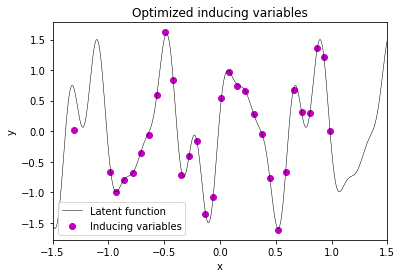

In [8]:
plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.scatter(X_m_opt, mu_m_opt, label='Inducing variables', c='m')
plt.title('Optimized inducing variables')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-1.5, 1.5)
plt.legend();

### Prediction

The parameters of the approximate posterior $q(\mathbf{f}_*)$ can now be computed with equations $(8)$ and $(9)$.
An approach for an implementation that scales with $O(nm^2)$ is described [here](https://gpflow.readthedocs.io/en/develop/notebooks/theory/SGPR_notes.html#Prediction) (note that their notation uses $q(\mathbf{u})$ instead of our $\phi(\mathbf{f}_m)$ and $p(\mathbf{f}^*)$ instead of our $q(\mathbf{f}_*)$). Here, we use a naive implementation.

In [9]:
@jit
def q(X_test, theta, X_m, mu_m, A_m, K_mm_inv):
    """
    Approximate posterior. 
    
    Computes mean and covariance of latent 
    function values at test inputs X_test.
    """
    
    K_ss = kernel(X_test, X_test, theta)
    K_sm = kernel(X_test, X_m, theta)
    K_ms = K_sm.T

    f_q = (K_sm @ K_mm_inv).dot(mu_m)
    f_q_cov = K_ss - K_sm @ K_mm_inv @ K_ms + K_sm @ K_mm_inv @ A_m @ K_mm_inv @ K_ms
    
    return f_q, f_q_cov

Predicting function values at inputs `X_test` shows that the sparse Gaussian process is a good approximation to the true latent function inside the training data region. Predictions outside the training data region converge to  $0$  and have high variance.

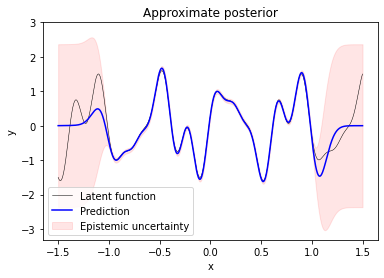

In [10]:
f_test, f_test_cov = q(X_test, theta_opt, X_m_opt, mu_m_opt, A_m_opt, K_mm_inv)
f_test_var = np.diag(f_test_cov)
f_test_std = np.sqrt(f_test_var)

plt.plot(X_test, f_true, label='Latent function', c='k', lw=0.5)
plt.plot(X_test, f_test, label='Prediction', c='b')
plt.fill_between(X_test.ravel(), 
                 f_test.ravel() + 2 * f_test_std, 
                 f_test.ravel() - 2 * f_test_std,
                 label='Epistemic uncertainty',
                 color='r', alpha=0.1)
plt.title('Approximate posterior')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(None, 3.0)
plt.legend();

The predicted variance covers model uncertainty or epistemic uncertainty only. To represent the uncertainty of noisy predictions we would aditionally have to include aleatoric uncertainty by adding `sigma_y ** 2` to predicted variances `f_test_var` (not shown here).

### Visualizing the optimization process

The following animation visualizes the optimization of a sparse Gaussian process. At each optimization step it shows the updated placement of inducing variables together with predictions made by the approximate posterior. One can clearly see how the optimization process stretches the initially narrow interval of inducing inputs so that prediction accuracy can increase over time.

In [11]:
theta_0 = jnp.array([1.0, 1.0])
theta_steps = [theta_0]

X_m_0 = X_m
X_m_steps = [X_m_0]

def callback(xk):
    theta, X_m = unpack_params(xk)
    theta_steps.append(theta)
    X_m_steps.append(X_m)
    return False

# Run optimization of kernel parameters and
# inducing inputs again and store their values
# at each step in global variables theta_steps
# and X_m_steps.
minimize(fun=nlb_fn(X, y, sigma_y),
         x0=pack_params(theta_0, X_m_0),
         method='L-BFGS-B', jac=True, 
         callback=callback);

In [12]:
from gaussian_processes_util import generate_animation
from IPython.display import HTML

# Generate animation with one frame per optimization step
anim = generate_animation(theta_steps, X_m_steps, X_test, f_true, X, y, sigma_y, phi_opt, q)

# Show animation widget
HTML(anim.to_jshtml())

## Related

A Tensorflow-based implementation of \[1\] is provided by the GPflow project with the [SGPR](https://gpflow.readthedocs.io/en/master/gpflow/models/index.html#gpflow.models.SGPR) model. One limitation of the algorithm described in \[1\] is that it cannot be applied to mini-batches of training data. A stochastic variational inference approach that additionally supports training with mini-batches is described in \[3\], for example. These two papers have strongly influenced further papers on scalable Gaussian processes.

## References

\[1\] Titsias, M. (2009). [Variational learning of inducing variables in sparse Gaussian processes](http://proceedings.mlr.press/v5/titsias09a.html). In International Conference on Artificial Intelligence and Statistics (pp. 567–574).

\[2\] Matthews, A., Wilk, M., Nickson, T., Fujii, K., Boukouvalas, A., León-Villagrá, P., Ghahramani, Z., & Hensman, J. (2017). [GPflow: A Gaussian process library using TensorFlow](https://jmlr.org/papers/v18/16-537.html). Journal of Machine Learning Research 18(40), 1-6.

\[3\] Hensman, J., Fusi, N., & Lawrence, N. (2013). [Gaussian Processes for Big Data](https://arxiv.org/abs/1309.6835). In Proceedings of the Twenty-Ninth Conference on Uncertainty in Artificial Intelligence (pp. 282–290).